In [1]:
import numpy as np
import pandas as pd
import csv
import math
from sklearn.model_selection import train_test_split
import random
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
np.random.seed(0)

In [3]:
def calculateInitialGinni(training_set):
    training_set=np.asarray(training_set).astype("float")
    initial_ginni = ginni(training_set)
    return initial_ginni

In [4]:
def calculateIG(parentGinni, currentGinni):
    return (parentGinni-currentGinni)

In [5]:
def ginni(training_set):
    if(training_set.shape[0]==0):
        return 0
    training_set1=training_set[:,-1]
    unique_elements, counts_elements = np.unique(training_set1, return_counts=True) # get the count and type of label in the rows
    dic=dict(zip(unique_elements,counts_elements)) # create a dictionary with the label and count 
    p = []
    for label in dic:
        p.append(dic[label]/float(training_set1.shape[0])) # get the probability of every label into an array so that it is easy for numpy calculation
    return 1-np.sum(np.multiply(p,p))

In [6]:
def ginniVal(training_set, column_index, value):
    training_set_left = [row for row in training_set if float(row[column_index]) >= value]
    training_set_right = [row for row in training_set if float(row[column_index])< value]
    training_set_left = np.asarray(training_set_left,dtype='float')
    training_set_right = np.asarray(training_set_right,dtype='float')
    p =float((training_set_left.shape[0])/(training_set_left.shape[0]+training_set_right.shape[0]))
    return p*ginni(training_set_left)+(1-p)*ginni(training_set_right)

In [7]:
def findSplit(training_set,featureList):
    local_ginni=0
    local_column=None
    best_ginni=1
    best_column=0
    col_mean_final=0
    bestIg=0
    parentGinni=calculateInitialGinni(training_set)
    
    for col in featureList:
        col_data= [float(row[col]) for row in training_set]
#         print("Column data for ",col, " is :",col_data)
        col_mean=float(np.sum(col_data)/len(col_data)) # get col_mean for the remaining rows
        true_rows, false_rows= partition(training_set,col,col_mean)
        if(len(true_rows) == 0 or len(false_rows)==0):
            continue
        local_ginni= ginniVal(training_set,col,col_mean)
        localIg= calculateIG(parentGinni,local_ginni)
        if localIg>= bestIg:
            bestIg=localIg
            best_ginni=local_ginni
            best_column = col
            col_mean_final=col_mean
    return  bestIg,best_column,col_mean_final

In [8]:
def partition(training_set, column_index, value):
    true_rows= [row for row in training_set if float(row[column_index]) >= value]
    false_rows = [row for row in training_set if float(row[column_index])< value]
    return true_rows, false_rows

In [9]:
# get the class of data in case it cant be split further i.e all the data in this particular class belong to
# the same class. So we just take the first label and set it as the output label for the decision tree node
def getClass(training_set, column_index,value):
    true_label= None
    false_label=None
    true_rows= [row for row in training_set if float(row[column_index]) >= value]
    false_rows = [row for row in training_set if float(row[column_index])< value]
    
    if len(true_rows)>0:
#         true_rows=np.asarray(true_rows)
        true_label = true_rows[0][-1]
    if len(false_rows)>0:
        false_label= false_rows[0][-1]
        
    if false_label==1:
        false_label="class1"
    if true_label==0:
        true_label="class0"
    if false_label==0:
        false_label="class0"
    if true_label==1:
        true_label="class1"
    if len(true_rows)> len(false_rows):
        return true_label
    else:
        return false_label
#     return true_label, false_label

In [10]:
class DecisionTree():
    def __init__(self):
        self.tree = {}
    def learn(self, training_set,index,featureList,features):
        #implement this function
        value=0
        true_index=0
        false_index=0
        random_feature_list= random.sample(featureList,features) 
        gain,column_name,value = findSplit(training_set,random_feature_list)
#         print("Value is::",value,"for column ::",column_name)
        #check terminating criteria with gini= 0 which means it is evenly being split
        if gain==0:
            return getClass(training_set, column_name, value)
        true_rows, false_rows = partition(training_set,column_name,value)
        
        # Make the recursive call for both true and false rows and get the index
        true_index = self.learn(true_rows, 2*index,featureList, features)
        
        false_index= self.learn(false_rows,2*index+1,featureList,features)
        
        #use the index the insert the data required into the tree
       
        self.tree[index]=[column_name,value,{"true_rows":true_index,"false_rows":false_index}]
        return index
    

    def classify(self, test_instance):
#         print(self.tree)
        result = 0 # baseline: always classifies as 0
        index=1 # root index
        while 1:
            value= self.tree[index]
            column_num= value[0]
            values=value[1]
            if float(test_instance[column_num])>=float(values):
                result= value[2]["true_rows"] # the third item in the tree is a dictionary that contains both the T and F ids
            else:
                result=value[2]["false_rows"]
            if result=="class1" or result=="class0":
                break
            else:
                index=result
        if result=="class1":
            result="1"
        else:
            result="0"
        return result

In [11]:
def reduceDataset(train,no_Elements):
    # reduce the count of dataset to no_Elements
#     print("Number of features is:::", features)
    train= train.sample(n=no_Elements)
    random_dataset= train.values
    random_subset = train.iloc[:, :-1]
    featureList=[i for i in range(random_subset.shape[1])]
    #selected_features = random.sample(featureList,features)
#     print("Feature List is:::", selected_features)
    train=train.values
    return train,featureList

In [12]:
def buildForest(train, features, count_trees, no_Elements):
    forest=[]
    for i in range(count_trees):
        dataset,featureList= reduceDataset(train,no_Elements)
#         featureList.sort()
        train_dataset=dataset.tolist()
        tree = DecisionTree()
        tree.learn( train_dataset,1,featureList,features)
        forest.append(tree)
#         print("Done with tree ",(i+1))#,"Features :",featureList)
    return forest

In [13]:
def getAccuracy(test, forest):
    result_rows=[]
    test=test.values.tolist()
    for instance in test:
        result_inst=[]
        for tree in forest:
            result=tree.classify(instance)
            result_inst.append(result)
        result_rows.append(result_inst)
    final_result=[]
    for i in range(len(result_rows)):
        final_result.append(max(set(result_rows[i]), key=result_rows[i].count))
    
    count=0
    
    for i in range(len(final_result)):
        if float(final_result[i])==(test[i][-1]):
            count=count+1
    return (count*100)/(len(final_result))
    #print("Accuracy is ",(count*100)/(len(final_result)))

In [14]:
def random_forest():
    df= pd.read_csv('spam.data.txt',header=None,delimiter=r"\s+")
    train, test = train_test_split(df, test_size=0.3)
    no_Features= train.shape[1]
    #trimmed_features_count= 49#int(math.sqrt(no_Features)*2)
#     print(trimmed_features_count)
    count_trees=20
    X_axis=[]
    Y_axis=[]
    error=0
    no_elements=1500 #2800
    for i in range(1,57,2):
        forest=buildForest(train,i,count_trees,no_elements)
        accuracy=getAccuracy(test,forest)
        #print("Accuracy is ",accuracy)
        error=100.0-accuracy
        print("Done with iteration ",i," with accuracy of ",accuracy)
        X_axis.append(i)
        Y_axis.append(error)
        
        
    plt.plot(X_axis, Y_axis)
    plt.xlabel(' Parameter m') 
    # naming the y axis 
    plt.ylabel('Error') 
    # giving a title to my graph 
    plt.title('Parameter m vs Error') 
    # function to show the plot 
    plt.show() 

Done with iteration  1  with accuracy of  85.66256335988415
Done with iteration  3  with accuracy of  93.33816075307747
Done with iteration  5  with accuracy of  94.20709630702389
Done with iteration  7  with accuracy of  94.27950760318609
Done with iteration  9  with accuracy of  94.64156408399711
Done with iteration  11  with accuracy of  94.20709630702389
Done with iteration  13  with accuracy of  95.22085445329472
Done with iteration  15  with accuracy of  94.64156408399711
Done with iteration  17  with accuracy of  94.78638667632151
Done with iteration  19  with accuracy of  94.64156408399711
Done with iteration  21  with accuracy of  93.84503982621288
Done with iteration  23  with accuracy of  94.13468501086169
Done with iteration  25  with accuracy of  94.64156408399711
Done with iteration  27  with accuracy of  94.27950760318609
Done with iteration  29  with accuracy of  94.56915278783491
Done with iteration  31  with accuracy of  94.42433019551049
Done with iteration  33  with

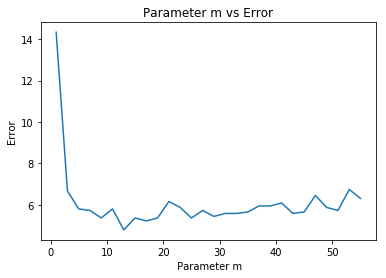

In [15]:
if __name__ == "__main__":
    random_forest()